![title](https://i.imgur.com/XXrmxpp.jpeg)

> *Avatar: The Last Airbender*, known as *Avatar: The Legend of Aang* in some regions, is an American animated television series produced by Nickelodeon Animation Studios. It aired on Nickelodeon for three seasons, from February 2005 to July 2008.
> <br>
>
> Avatar is set in an Asiatic-like world in which certain people can manipulate one of the four elements — water, earth, fire, or air—with telekinetic variants of the Chinese martial arts known as "bending". The only individual who can bend all four elements, the "Avatar", is responsible for maintaining balance between the world's four nations, and serves as the bridge between the physical world and the spirit world. 
> <br>
>
> @Wikipedia

![](https://64.media.tumblr.com/b1dc757e072b20026108c8cfcd640c85/tumblr_nvxnup0gzN1uic2oco1_640.jpg)

*Avatar: The Last Airbender* is as popular today as it was before. It is still remaining in the top 10 [TV shows](https://www.imdb.com/chart/toptv/?ref_=nv_tvv_250) on the IMDb service and it is one of the most highly rated [animated TV shows](https://www.imdb.com/search/title/?genres=animation&sort=user_rating,desc&title_type=tv_series,mini_series&num_votes=5000,&pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=f85d9bf4-1542-48d1-a7f9-48ac82dd85e7&pf_rd_r=AG9MZFF3D62SB6J5RX24&pf_rd_s=right-6&pf_rd_t=15506&pf_rd_i=toptv&ref_=chttvtp_gnr_3) as of this writing. 





In [57]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sqlalchemy import create_engine

import re
from IPython.display import display

from wordcloud import WordCloud, STOPWORDS

Dataset is taken from [Kaggle](https://www.kaggle.com/ekrembayar/avatar-the-last-air-bender). <br><br>
There are 4 CSV files in the dataset: 
- avatar.csv
- avatar_data.csv
- scenes.csv
- series_names.csv

In [2]:
# Reading data from .csv files

avatar = pd.read_csv('tables/avatar.csv', encoding = "ISO-8859-1", index_col=0)
data = pd.read_csv('tables/avatar_data.csv', index_col=0)
scenes = pd.read_csv('tables/scenes.csv', encoding = "ISO-8859-1", index_col=0)
series = pd.read_csv('tables/series_names.csv', index_col=0)

In [3]:
# Writing records stored in DataFrames to a SQL database
# for further working with the query language

engine = create_engine('sqlite://', echo=False)

avatar.to_sql('avatar', con=engine, index='False')
data.to_sql('data', con=engine, index='False')
scenes.to_sql('scenes', con=engine, index='False')
series.to_sql('series', con=engine, index='False')

<h2 align="center"> Preliminary Data Analysis </h2> 

First of all, let's look at our data. We need to analyze the content of the tables to understand what we are going to work with and find out if there are any missing values 

In [4]:
# names of table columns

def print_table_columns(table_name, table_df):
    print(table_name)
    for table in table_df.columns.tolist():
        print(table, end=' | ')
        
print_table_columns('Avatar', avatar)
print_table_columns('\n\nData', data)
print_table_columns('\n\nScenes', scenes)
print_table_columns('\n\nSeries', series)

Avatar
id | book | book_num | chapter | chapter_num | character | full_text | character_words | writer | director | imdb_rating | 

Data
book | director | imdb_rating | book_chapt | true_chapt | series_rating | 

Scenes
id | scene_description | 

Series
book | series_rating | halfway | 

In [5]:
avatar.head(3)

,id,book,book_num,chapter,chapter_num,character,full_text,character_words,writer,director,imdb_rating
1,1,Water,1,The Boy in the Iceberg,1,Katara,Water. Earth. Fire. Air. My grandmother used t...,Water. Earth. Fire. Air. My grandmother used t...,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
2,2,Water,1,The Boy in the Iceberg,1,Scene Description,"As the title card fades, the scene opens onto ...",NaN,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1
3,3,Water,1,The Boy in the Iceberg,1,Sokka,It's not getting away from me this time. [Clos...,It's not getting away from me this time. Watc...,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",Dave Filoni,8.1


In [6]:
data.head(3)

,book,director,imdb_rating,book_chapt,true_chapt,series_rating
1,Water,Dave Filoni,8.1,1,0,8.336991
2,Water,Dave Filoni,8.3,2,1,8.336991
3,Water,Lauren MacMullan,8.5,3,2,8.336991


In [7]:
scenes.head(3)

,id,scene_description
1,3,[Close-up of the boy as he grins confidently o...
2,5,[Happily surprised.]
3,6,[Close-up of Sokka; whispering.]


In [8]:
series.head(3)

,book,series_rating,halfway
1,Earth,8.730077,31.5
2,Fire,8.862371,53.0
3,Water,8.336991,10.5


In [9]:
# Columns with missing values

print(avatar.columns[avatar.isna().any()].tolist())
print(data.columns[data.isna().any()].tolist())
print(scenes.columns[scenes.isna().any()].tolist())
print(series.columns[series.isna().any()].tolist())

['character_words', 'imdb_rating']
[]
[]
[]


There are only two columns with NaN values in the dataset. It is normal for the "character_words" column to have no values in some cases, since the characters may not say anything in certain scenes. But it is strange that there are missing values in the "imdb_rating" column of the "Avatar" table. <br>
Let's see at these missing values and check if it is all right with the data in the column with the same name of another table

In [10]:
# Number of rows with missed values in the "imdb_rating" column

df = avatar[['chapter_num', 'id', 'imdb_rating']].groupby(['chapter_num']).\
count().query('id != imdb_rating')

print('Missed: ', int(df['id']) - int(df['imdb_rating']))
df

Missed:  161


,id,imdb_rating
chapter_num,,
20,509,348


In [11]:
# The first and the last rows with the NaN imdb_rating
avatar[avatar['imdb_rating'].isnull()].iloc[[0, -1]]

,id,book,book_num,chapter,chapter_num,character,full_text,character_words,writer,director,imdb_rating
4460,4460,Water,1,"The Siege of the North, Part 2",20,Scene Description,The episode opens to the Northern Water Tribe ...,NaN,Aaron Ehasz,Dave Filoni,NaN
4620,4620,Water,1,"The Siege of the North, Part 2",20,Scene Description,Fades to credits.,NaN,Aaron Ehasz,Dave Filoni,NaN


In [12]:
# Info about the 20th episode in the "Data" table
data[data['book_chapt'] == 20]

,book,director,imdb_rating,book_chapt,true_chapt,series_rating
20,Water,Dave Filoni,9.7,20,19,8.336991


Some of the values (161) in the "imdb_rating" column of the "Avatar" table were actually missed. All of them are connected to the 20th episode. But there is a correct rating value for this episode in the "Data" table. Therefore, we will mainly use this table to analyze ratings

In [13]:
# total number of episodes 
data['book_chapt'].count()

61

In [14]:
# number of episodes in each book sorted in chronological order
episodes_cnt = engine.execute("""
                              SELECT book, COUNT(1) AS episodes
                              FROM data
                              GROUP BY book
                              ORDER BY book_chapt
                              """)
episodes_cnt_df = pd.DataFrame(episodes_cnt.fetchall())
episodes_cnt_df.columns = episodes_cnt.keys()

episodes_cnt_df

,book,episodes
0,Water,20
1,Earth,20
2,Fire,21


<h2 align="center"> IMDb Ratings </h2> 

In [15]:
sns.set_theme(style="darkgrid")

<h3 align='center'> Description of IMDb Ratings data </h3>

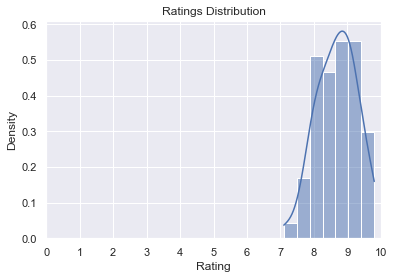

count    61.000000
mean      8.683607
std       0.598660
min       7.100000
25%       8.200000
50%       8.700000
75%       9.100000
max       9.800000
Name: imdb_rating, dtype: float64

In [16]:
sns.histplot(data['imdb_rating'], kde=True, stat="density")
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.xticks(range(0, 11))

plt.show()

data['imdb_rating'].describe()

We can see that most of the TV show episodes have very high IMDb Ratings. <br>
Minimum rating value is 7.1 and the mean is 8.68. <br>
Half of the episodes received a rating of more than 8.7 and a quarter received more than 9.1. <br>
These are extremely good results and they show the love of viewers for the TV show

<h3 align='center'> Books and Chapters Ratings </h3>

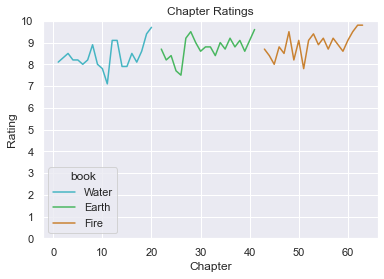

In [17]:
sns.lineplot(x='book_chapt', y='imdb_rating', hue='book', data=data,
             palette=['#45b5c3', '#49b760', '#c98232'])

plt.title('Chapter Ratings')
plt.xlabel('Chapter')
plt.ylabel('Rating')
plt.yticks(range(0, 11))

plt.show()

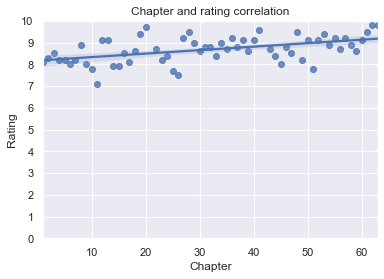

In [18]:
sns.regplot(x='book_chapt', y='imdb_rating', data=data)
plt.title('Chapter and rating correlation')
plt.xlabel('Chapter')
plt.ylabel('Rating')
plt.yticks(range(0, 11))

plt.show()

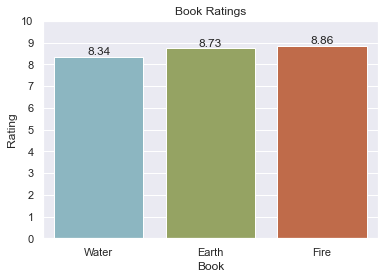

In [19]:
fig, ax = plt.subplots()

graph = sns.barplot(ax=ax, x='book', y='series_rating', data=data,
            palette=['#83bbca', '#9bae58', '#d36336'])
plt.title('Book Ratings')
plt.xlabel('Book')
plt.ylabel('Rating')
plt.yticks(range(0, 11))

for p in graph.patches:
    graph.annotate('{:.2f}'.format(p.get_height()), (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom')

plt.show()

On the graph "Chapter and rating correlation" we can see a positive correlation between the episode number and its rating, so we can assume that the audience's opinion of the TV show has improved over time: the viewers enjoyed the show more and more as they continued watching it. <br>
Avatar's ratings increased from season to season and the final season had the highest rating of all. <br>
The story of Avatar came to a clear end, it had an epic conclusion and gave the audience an emotional attachment to the TV show as a real legend or saga. It may be the main factor in its popularity and the undying interest in it throughout all seasons

<h2 align='center'> Directors </h2>

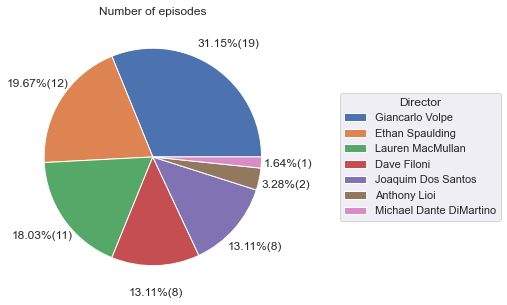

In [20]:
# Number of directed episodes

dir_episodes_cnt = (data[['director', 'book_chapt']].groupby('director')
                    .count().sort_values('book_chapt', ascending=False))

plt.figure(figsize=(8,5))

plt.pie(dir_episodes_cnt['book_chapt'], labels=None, pctdistance=1.25,
        autopct=lambda p: '{:.2f}%({:.0f})'.format(p, (p/100)*dir_episodes_cnt['book_chapt'].sum()))
plt.title("Number of episodes")
plt.legend(title='Director', loc="center right", labels=dir_episodes_cnt.index, 
           bbox_to_anchor=(1.3, 0, 0.5, 1))

plt.show()

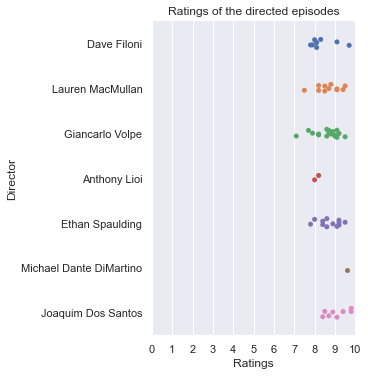

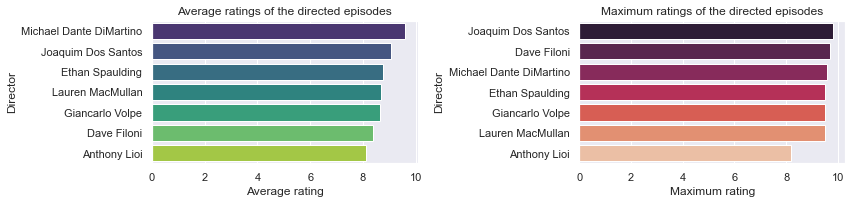

In [21]:
# Ratings of the directed episodes

sns.catplot(x='imdb_rating', y='director', data=data)
plt.title('Ratings of the directed episodes')
plt.xlabel('Ratings')
plt.ylabel('Director')
plt.xticks(range(0, 11))

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12,3))

avg_rating = (data[['director', 'imdb_rating']].groupby('director')
              .mean().sort_values('imdb_rating', ascending=False))

max_rating = (data[['director', 'imdb_rating']].groupby('director')
              .max().sort_values('imdb_rating', ascending=False))

def draw_barplot(val_type, idx, val_type_df, colors):
    sns.barplot(ax=ax[idx], x='imdb_rating', y=val_type_df.index, data=val_type_df,
                palette=colors)
    ax[idx].set_xlabel('{} rating'.format(val_type))
    ax[idx].set_ylabel('Director')
    ax[idx].set_title('{} ratings of the directed episodes'.format(val_type))

draw_barplot('Average', 0, avg_rating, 'viridis')
draw_barplot('Maximum', 1, max_rating, 'rocket')

fig.tight_layout()

plt.show()

As we can see, Giancarlo Volpe has directed the most number of episodes, but the average rating of his episodes is not the best. This is partly due to the fact that the episode with the lowest rating belongs to him. <br>
Michael Dante DiMartino has directed only one episode, and this episode received quite high rating. <br>
The episode with the highest rating of all belongs to Joaquim Dos Santos. The average rating of all his episodes is also high: he ranks second (after Michael Dante DiMartino).

<h2 align='center'> Writers </h2>

Let's extract data we need (writer, imdb_rating, book_chapt) from the "Avatar" table. There is no "book_chapter" column in this table, but there are "book_num" and "chapter_num". We remember that there are 20 episodes in the first two seasons, so we can easily get the book chapter. <br>
We also remember that there was a problem with the rating of the 20th episode in the "Avatar" table. In our new table we will need to set correct rating for this episode.

In [22]:
writer_ratings = avatar[['writer', 'book_num', 'chapter_num', 'imdb_rating']].drop_duplicates()
writer_ratings['book_chapt'] = (writer_ratings['book_num'] - 1) * 20 + writer_ratings['chapter_num'] 
writer_ratings = writer_ratings.drop(['book_num', 'chapter_num'], 1)

writer_ratings.loc[writer_ratings['book_chapt'] == 20, 'imdb_rating'] = \
float(data.loc[data['book_chapt'] == 20, 'imdb_rating'])

writer_ratings.head(20)

,writer,imdb_rating,book_chapt
1,"<U+200E>Michael Dante DiMartino, Bryan Konietz...",8.1,1
224,"Michael Dante DiMartino, Bryan Konietzko, Aaro...",8.3,2
406,Michael Dante DiMartino,8.5,3
679,Nick Malis,8.2,4
983,John O'Bryan,8.2,5
1206,Matthew Hubbard,8.0,6
1444,Aaron Ehasz,8.2,7
1625,Michael Dante DiMartino,8.9,8
1846,John O'Bryan,8.0,9
2069,James Eagan,7.8,10


<h3> Comparing working alone and in a team while writing an episode script </h3>

In [23]:
# Adding a column to the table "writer_ratings" with the values 
# "Alone" or "Team" based on number of writers

writer_ratings['writers_num'] = (writer_ratings['writer']
                                 .apply(lambda x : 'Alone' if len(x.split(', ')) == 1 else 'Team'))
writer_ratings = writer_ratings.sort_values('writers_num')
writer_ratings

,writer,imdb_rating,book_chapt,writers_num
6882,Tim Hedrick,8.8,31,Alone
6032,Elizabeth Welch Ehasz,9.5,27,Alone
6251,Joshua Hamilton,9.0,28,Alone
6496,Aaron Ehasz,8.6,29,Alone
6673,John O'Bryan,8.8,30,Alone
...,...,...,...,...
2967,"John O'Bryan, Aaron Ehasz",7.9,14,Team
2823,"Bryan Konietzko, Michael Dante DiMartino",9.1,13,Team
224,"Michael Dante DiMartino, Bryan Konietzko, Aaro...",8.3,2,Team
8645,"Michael Dante DiMartino, Bryan Konietzko",9.1,39,Team


First glance at the differences between the samples:

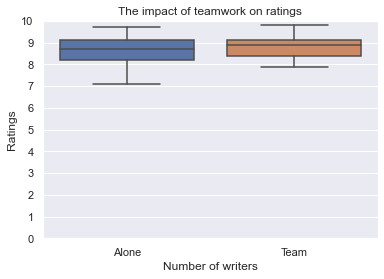

,avg_rating,max_rating,min_rating,std_dev,samlpe_size
writers_num,,,,,
Alone,8.641667,9.7,7.1,0.601004,48
Team,8.838462,9.8,7.9,0.586712,13


In [24]:
sns.boxplot(x='writers_num', y='imdb_rating', data=writer_ratings)
plt.title('The impact of teamwork on ratings')
plt.ylabel('Ratings')
plt.xlabel('Number of writers')
plt.yticks(range(0, 11))

plt.show()

comparative_values = (writer_ratings[['writers_num', 'imdb_rating']].groupby('writers_num').mean()
                      .rename(columns = {'imdb_rating' : 'avg_rating'}))
comparative_values['max_rating'] = (writer_ratings[['writers_num', 'imdb_rating']]
                                    .groupby('writers_num').max()['imdb_rating'])
comparative_values['min_rating'] = (writer_ratings[['writers_num', 'imdb_rating']]
                                    .groupby('writers_num').min()['imdb_rating'])
comparative_values['std_dev'] = (writer_ratings[['writers_num', 'imdb_rating']]
                                    .groupby('writers_num').std()['imdb_rating'])
comparative_values['samlpe_size'] = (writer_ratings[['writers_num', 'imdb_rating']]
                                    .groupby('writers_num').count()['imdb_rating'])
comparative_values

At first glance, it seems like teamwork was more successful: the first three measures (average, maximum, minimum) are greater for episodes that several people worked on. But there are many more episodes than one person worked on, and the range of these ratings is greater than for teams. It means that we can not make exact conclusions right now. We need to do a statistical test to determine if there is a significant difference between the means of two groups.

In [25]:
alone_writers = writer_ratings.loc[writer_ratings['writers_num'] == 'Alone']
team_writers = writer_ratings.loc[writer_ratings['writers_num'] == 'Team']

To select a suitable test, we need to check the samples for the normality of the distribution. <br>
We are going to use two methods for checking normality:
- visual method (histogram)
- normality test (Shapiro-Wilk test)

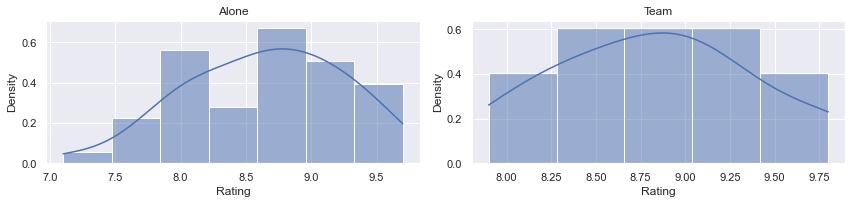

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12,3))

def draw_histplot(val_type, idx, df):
    sns.histplot(df['imdb_rating'], kde = True, stat='density', ax=ax[idx])
    ax[idx].set_title('{}'.format(val_type))
    ax[idx].set_xlabel('Rating')
    
draw_histplot('Alone', 0, alone_writers)
draw_histplot('Team', 1, team_writers)

fig.tight_layout()

plt.show()

In [27]:
def shapiro_pvalue(val, alpha, df):
    pvalue = stats.shapiro(df['imdb_rating']).pvalue
    if pvalue > alpha:
        print('Sample "{}" looks Gaussian (fail to reject H0)'.format(val))
        print('p = {:.2f}'.format(pvalue))
    else:
        print('Sample "{}" does not look Gaussian (reject H0)'.format(val))
        print('p = {:.2f}'.format(pvalue))
    print()
    
shapiro_pvalue('Alone', 0.05, alone_writers)
shapiro_pvalue('Team', 0.05, team_writers)

Sample "Alone" looks Gaussian (fail to reject H0)
p = 0.53

Sample "Team" looks Gaussian (fail to reject H0)
p = 0.75



> The normality test compares the scores in the sample to a normally distributed set of scores with the same mean and standard deviation. <br>
> The null hypothesis is that "sample distribution is normal". If the test is significant (p-value is less than alpha), the distribution is non-normal. <br>

We don't see the usual bell shapes on the plots, but the Shapiro-Wilk test tells us that samples are normally distributed. For small sample sizes, normality tests have little power to reject the null hypothesis and therefore small samples most often pass normality tests. Therefore, it is better to rely on the graphical interpretation in this case and conclude that sample distribution is not normal. <br>

We will use the Mann–Whitney U test as the most appropriate in this case.
> In statistics, the Mann–Whitney U test is a nonparametric test of statistical significance for determining whether two independent samples were taken from a population with the same distribution.

Let's take the statement "There is no difference between working alone and in a team while writing an episode script" as a null hypothesis for the Mann–Whitney U test. 

In [28]:
alpha = 0.05
p = stats.mannwhitneyu(alone_writers['imdb_rating'], team_writers['imdb_rating']).pvalue

if p > alpha:
    print('The differences between the samples are statistically insignificant (fail to reject H0)')
    print('p = {:.2f}'.format(p))
else:
    print('The differences between the samples are statistically significant (reject H0)')
    print('p = {:.2f}'.format(p))

The differences between the samples are statistically insignificant (fail to reject H0)
p = 0.19


Conclusion <br><br>

We do not have sufficient evidence to conclude that there is a difference between working alone and in a team while writing an episode script. Any differences between the samples are due to the sampling errors.

<h2 align='center'> Characters </h2>

Now let's take a look at the number of character phrases over the seasons

In [204]:
characters = (avatar[['character', 'book', 'book_num', 'chapter_num', 'character_words']]
              .loc[avatar['character'] != 'Scene Description'])
characters['book_chapt'] = (characters['book_num'] - 1) * 20 + characters['chapter_num'] 
characters = characters.drop('chapter_num', 1)

characters

,character,book,book_num,character_words,book_chapt
1,Katara,Water,1,Water. Earth. Fire. Air. My grandmother used t...,1
3,Sokka,Water,1,It's not getting away from me this time. Watc...,1
5,Katara,Water,1,"Sokka, look!",1
6,Sokka,Water,1,"Sshh! Katara, you're going to scare it away. ...",1
8,Katara,Water,1,"But, Sokka! I caught one!",1
...,...,...,...,...,...
13380,Mai,Fire,3,I look like a man.,61
13381,Suki,Fire,3,And why did you paint me firebending?,61
13382,Sokka,Fire,3,I thought it looked more exciting that way. O...,61
13383,Iroh,Fire,3,"Hey, my belly's not that big anymore. I've rea...",61


In [342]:
phrases_num = characters[['character', 'book', 'book_num', 'book_chapt']]

phrases_num = phrases_num.groupby(['character', 'book', 'book_num']).count()
phrases_num.reset_index(level='book_num', inplace=True)          
phrases_num.reset_index(level='book', inplace=True)

phrases_num['sum_phrases'] = phrases_num.groupby('character').sum()['book_chapt']

phrases_num = phrases_num.sort_values(['sum_phrases', 'book_num'], ascending=[False, True])
phrases_num.reset_index(level='character', inplace=True)

phrases_num = phrases_num.head(17)
phrases_num

,character,book,book_num,book_chapt,sum_phrases
0,Aang,Water,1,818,1796
1,Aang,Earth,2,492,1796
2,Aang,Fire,3,486,1796
3,Sokka,Water,1,614,1639
4,Sokka,Earth,2,499,1639
5,Sokka,Fire,3,526,1639
6,Katara,Water,1,636,1437
7,Katara,Earth,2,413,1437
8,Katara,Fire,3,388,1437
9,Zuko,Water,1,174,776


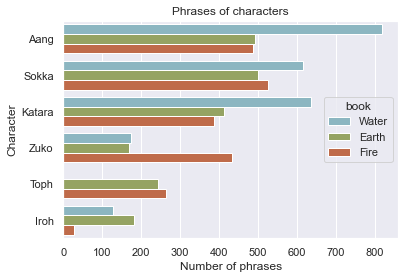

In [343]:
sns.barplot(x='book_chapt', y='character', hue='book', data=phrases_num, 
            palette=['#83bbca', '#9bae58', '#d36336'])
plt.xlabel('Number of phrases')
plt.ylabel('Character')
plt.title('Phrases of characters')

plt.show()